# Data 

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns 

import tqdm

## Load Targets

In [2]:
y_Ag = pd.read_csv("./dataset/Ag.csv", encoding='utf-8', index_col=0)
y_Au = pd.read_csv("./dataset/Au.csv", encoding='utf-8', index_col=0)
y_Cu = pd.read_csv("./dataset/Cu.csv", encoding='utf-8', index_col=0)

y_dict = {"Ag":y_Ag, "Au":y_Au, "Cu":y_Cu}
indexs = np.append(y_Ag.index.to_numpy(), [y_Au.index.to_numpy(), y_Cu.index.to_numpy()])
cols = y_Ag.columns

## Load Data & Interpolation to same shape

In [250]:
import cv2

y = []
x_tdos = []
x_pdos_r = []
x_pdos_adsorb = []
reshape_size = (2, 750)


for index in tqdm.tqdm(indexs):
    metal = index.split("-")[0]
    for col in cols:
        tdos = pd.read_csv("./dataset/%s/%s/%s/dos/TDOS.dat"%(metal, index, col), sep="\s+", names=["DOS", "Energy"], header=None)
        pdos_r = pd.read_csv("./dataset/%s/%s/%s/dos/PDOS_R.dat"%(metal, index, col), sep="\s+", names=["DOS", "Energy"], header=None)
        pdos_adsorb = pd.read_csv("./dataset/%s/%s/%s/dos/PDOS_adsorb.dat"%(metal, index, col), sep="\s+", names=["DOS", "Energy"], header=None)

        try:
            x_tdos.append(cv2.resize(tdos.to_numpy(), dsize=reshape_size, interpolation=cv2.INTER_CUBIC))
        except:
            print("./dataset/%s/%s/%s/dos/TDOS.dat"%(metal, index, col))
            continue
        x_pdos_r.append(cv2.resize(pdos_r.to_numpy(), dsize=reshape_size, interpolation=cv2.INTER_CUBIC))
        x_pdos_adsorb.append(cv2.resize(pdos_adsorb.to_numpy(), dsize=reshape_size, interpolation=cv2.INTER_CUBIC))
        y.append(y_dict[metal].loc[index][col])

    
y = np.array(y) # y shape (780,)
x_tdos = np.array(x_tdos) # x_tdos shape (780, 750, 2)
x_pdos_r = np.array(x_pdos_r)
x_pdos_adsorb = np.array(x_pdos_adsorb)

# reshape to (num, 1, 2, 1000)
# x_tdos = np.transpose(np.expand_dims(x_tdos, axis=1), (0, 1, 3, 2))
# x_pdos_r = np.transpose(np.expand_dims(x_pdos_r, axis=1), (0, 1, 3, 2))
# x_pdos_adsorb = np.transpose(np.expand_dims(x_pdos_adsorb, axis=1), (0, 1, 3, 2))

print("y shape", y.shape)
print("x_tdos shape", x_tdos.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  7.01it/s]

y shape (780,)
x_tdos shape (780, 750, 2)


In [352]:
x = np.stack([x_tdos[:, :, 0], 
               x_pdos_r[:, :, 0],
               x_pdos_adsorb[:, :, 0]], axis=2) # shape (780, 750, 3)
x = np.transpose(np.expand_dims(x, axis=1), (0, 1, 3, 2)) # shape (780, 1, 3, 750)

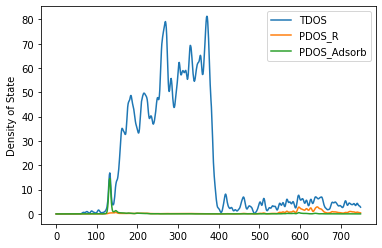

In [353]:
for i in range(1):
#     i = np.random.randint(0, y.shape[0]-1)        
    x_axis = np.arange(0, 750)
    plt.plot(x_axis, x[i][0][0], label="TDOS")
    plt.plot(x_axis, x[i][0][1], label="PDOS_R")
    plt.plot(x_axis, x[i][0][2], label="PDOS_Adsorb")
#     plt.xlabel("Energy(eV)")
    plt.ylabel("Density of State")
    plt.legend()
    plt.show()

## Regularization

In [341]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scaler = StandardScaler()
# x[:, 0, 0] = scaler.fit_transform(x[:, 0, 0])
# x[:, 0, 1] = scaler.transform(x[:, 0, 1])
# x[:, 0, 2] = scaler.transform(x[:, 0, 2])

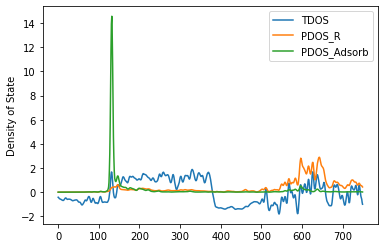

In [342]:
for i in range(1):
#     i = np.random.randint(0, y.shape[0]-1)        
    x_axis = np.arange(0, 750)
    plt.plot(x_axis, x[i][0][0], label="TDOS")
    plt.plot(x_axis, x[i][0][1], label="PDOS_R")
    plt.plot(x_axis, x[i][0][2], label="PDOS_Adsorb")
#     plt.xlabel("Energy(eV)")
    plt.ylabel("Density of State")
    plt.legend()
    plt.show()

# DOS Model Construction

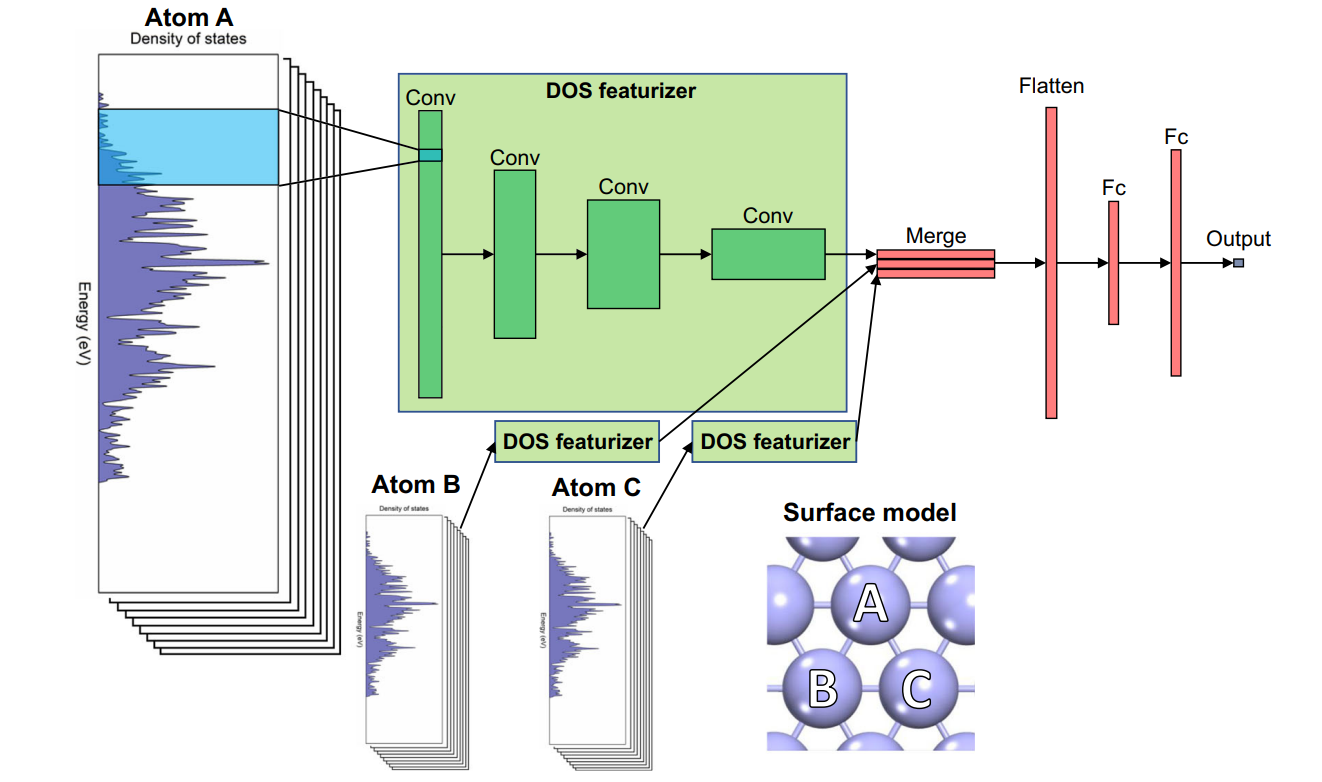

## Model Architecture


In [343]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### DeepConvNet
DOS Model with DeepConvNet

In [354]:
class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.dropout_rate = 0.5
        
        self.dos_featurizer = nn.Sequential(
            
            nn.Conv2d(1, 25, kernel_size=(1, 5)),
            
            nn.Conv2d(25, 25, kernel_size=(3, 1)),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Conv2d(25, 50, kernel_size=(1, 5)),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Conv2d(50, 100, kernel_size=(1, 5)),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),

            nn.Conv2d(100, 200, kernel_size=(1, 5)),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Flatten(),
            nn.Linear(8600, 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(8600*3, 128),
            nn.ReLU(),
            nn.Linear(128, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
        
        
        
    def forward(self, x):
        
        x = self.dos_featurizer(x)
#         output = torch.cat((output1, output2, output3), 1)
#         output = self.fc(output)
        
        return x
    
model = DeepConvNet().to(device)
summary(model, [(1, 3, 750)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 3, 746]             150
            Conv2d-2           [-1, 25, 1, 746]           1,900
       BatchNorm2d-3           [-1, 25, 1, 746]              50
              ReLU-4           [-1, 25, 1, 746]               0
         MaxPool2d-5           [-1, 25, 1, 373]               0
           Dropout-6           [-1, 25, 1, 373]               0
            Conv2d-7           [-1, 50, 1, 369]           6,300
       BatchNorm2d-8           [-1, 50, 1, 369]             100
              ReLU-9           [-1, 50, 1, 369]               0
        MaxPool2d-10           [-1, 50, 1, 184]               0
          Dropout-11           [-1, 50, 1, 184]               0
           Conv2d-12          [-1, 100, 1, 180]          25,100
      BatchNorm2d-13          [-1, 100, 1, 180]             200
             ReLU-14          [-1, 100,

### EEGNet

In [171]:
class DepthwiseConv2d(torch.nn.Conv2d):
    def __init__(self,
                 in_channels,
                 depth_multiplier=1,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 padding_mode='zeros'
                 ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode
        )
        
      ## conv with max norm  
#     def forward(self, x):
#     return F.conv2d(x, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
#                     self.padding, self.dilation, self.groups)

In [172]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=bias)
    
    def forward(self,x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [320]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.C = 3
        self.T = 750
        self.F1 = 16
        self.D = 2
        self.F2 = 32
        self.kernel_length = 64
        self.dropoutRate = 0.2
        
        # block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.F1, kernel_size=(1, 51), padding=(0, 25), stride=(1, 1), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(self.F1)
        self.depthwise1 = DepthwiseConv2d(self.F1, kernel_size=(self.C, 1), depth_multiplier=self.D, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(self.F1*self.D)
        self.relu1 = nn.ReLU()
#         self.lrelu1 = nn.LeakyReLU()
        self.averagePooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(p=self.dropoutRate)
        
        # block 2
        self.separableconv1 = SeparableConv2d(self.F1*self.D, self.F2, kernel_size=(1, 15), padding=(0, 7), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(self.F2)
        self.relu2 = nn.ReLU()
#         self.lrelu2 = nn.LeakyReLU()
        self.averagePooling2 = nn.AvgPool2d(kernel_size=(1,8))
        self.dropout2 = nn.Dropout(p=self.dropoutRate)
        self.flatten1 = nn.Flatten()
        
        self.dense1 = nn.Linear(self.F2*(self.T//32), 1)
        
        
    def forward(self, x):
        
        ## block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise1(x)
        x = self.batchnorm2(x)
        x = self.relu1(x)
#         x = self.lrelu1(x)
        x = self.averagePooling1(x)
        x = self.dropout1(x)
        
        ## block 2
        x = self.separableconv1(x)
        x = self.batchnorm3(x)
        x = self.relu2(x)
#         x = self.lrelu2(x)
        x = self.averagePooling2(x)
        x = self.dropout2(x)
        x = self.flatten1(x)
        x = self.dense1(x)        
        return x
    
model = EEGNet().to(device)
# print(model)
summary(model, [(1, 3, 750)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 3, 750]             816
       BatchNorm2d-2           [-1, 16, 3, 750]              32
   DepthwiseConv2d-3           [-1, 32, 1, 750]              96
       BatchNorm2d-4           [-1, 32, 1, 750]              64
         LeakyReLU-5           [-1, 32, 1, 750]               0
         AvgPool2d-6           [-1, 32, 1, 187]               0
           Dropout-7           [-1, 32, 1, 187]               0
            Conv2d-8           [-1, 32, 1, 187]             480
            Conv2d-9           [-1, 32, 1, 187]           1,024
  SeparableConv2d-10           [-1, 32, 1, 187]               0
      BatchNorm2d-11           [-1, 32, 1, 187]              64
        LeakyReLU-12           [-1, 32, 1, 187]               0
        AvgPool2d-13            [-1, 32, 1, 23]               0
          Dropout-14            [-1, 32

## Data Loader

In [355]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=8888)

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
x_val = torch.from_numpy(x_val).float().to(device)
y_val = torch.from_numpy(y_val).type(torch.float).to(device) # data type is long

train = torch.utils.data.TensorDataset(x_train, y_train)
val = torch.utils.data.TensorDataset(x_val, y_val)

batch_size = 128

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

## Training & Validation

In [356]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc, n_correct  = 0, 0, 0
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record
        avg_loss += loss.item()
        n_correct += torch.sum((torch.abs(pred[:, 0] - y) < torch.abs(0.1* y))).item()
#         if batch % 10 == 0:
#             loss, current = loss.item(), batch * len(x)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_acc = (n_correct / size * 100.0)  # scalar
    avg_loss /=  size
#     print(f"Train Error: \n Accuracy: {(avg_acc):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    return avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += torch.sum((torch.abs(pred[:, 0] - y) < torch.abs(0.1* y))).item()

    correct = (correct / size * 100.0 ) # scalar  test_loss /= len(test_loader)
    test_loss /=  size
    
#     print(f"Test Error: \n Accuracy: {(correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [357]:
epochs = 3000
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_acc = []
train_loss = []
val_acc = []
val_loss = []
for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss)
    val_acc.append(te_acc)
    val_loss.append(te_loss)
    
    if(t%10==0 or t==epochs-1):            
        print(f"Epoch {t+1}\n-------------------------------")
        print(f"Train Error: \n Accuracy: {(tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(te_acc):>0.1f}%, Avg loss: {te_loss:>8f} \n")


print("Done!")

# print("Saving model weight...")
# torch.save(model, "./DeepConvNet_model.pt")
# print("Save Done!")

/work/alanchen0922/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/work/alanchen0922/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([112])) that is different to the input size (torch.Size([112, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/work/alanchen0922/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 2.2%, Avg loss: 1.077503 

Test Error: 
 Accuracy: 1.9%, Avg loss: 1.594687 

Epoch 11
-------------------------------
Train Error: 
 Accuracy: 4.0%, Avg loss: 0.917811 

Test Error: 
 Accuracy: 2.6%, Avg loss: 1.067513 

Epoch 21
-------------------------------
Train Error: 
 Accuracy: 5.1%, Avg loss: 0.930232 

Test Error: 
 Accuracy: 3.8%, Avg loss: 1.482067 

Epoch 31
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.922017 

Test Error: 
 Accuracy: 5.8%, Avg loss: 1.521316 

Epoch 41
-------------------------------
Train Error: 
 Accuracy: 4.3%, Avg loss: 0.930601 

Test Error: 
 Accuracy: 5.8%, Avg loss: 1.269334 

Epoch 51
-------------------------------
Train Error: 
 Accuracy: 4.3%, Avg loss: 0.918910 

Test Error: 
 Accuracy: 4.5%, Avg loss: 1.436093 

Epoch 61
-------------------------------
Train Error: 
 Accuracy: 3.7%, Avg loss: 0.928799 

Test Error: 
 Accuracy: 3.8%, Avg loss: 1.14

Epoch 571
-------------------------------
Train Error: 
 Accuracy: 3.2%, Avg loss: 0.919735 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.538561 

Epoch 581
-------------------------------
Train Error: 
 Accuracy: 4.0%, Avg loss: 0.929609 

Test Error: 
 Accuracy: 5.1%, Avg loss: 1.477734 

Epoch 591
-------------------------------
Train Error: 
 Accuracy: 3.5%, Avg loss: 0.916335 

Test Error: 
 Accuracy: 1.3%, Avg loss: 1.270755 

Epoch 601
-------------------------------
Train Error: 
 Accuracy: 4.5%, Avg loss: 0.918967 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.473219 

Epoch 611
-------------------------------
Train Error: 
 Accuracy: 3.2%, Avg loss: 0.921283 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.420579 

Epoch 621
-------------------------------
Train Error: 
 Accuracy: 4.3%, Avg loss: 0.920995 

Test Error: 
 Accuracy: 3.8%, Avg loss: 1.334479 

Epoch 631
-------------------------------
Train Error: 
 Accuracy: 4.5%, Avg loss: 0.925960 

Test Error: 
 Accuracy: 5.1%, Avg lo

Epoch 1141
-------------------------------
Train Error: 
 Accuracy: 4.0%, Avg loss: 0.911648 

Test Error: 
 Accuracy: 3.8%, Avg loss: 1.356622 

Epoch 1151
-------------------------------
Train Error: 
 Accuracy: 4.2%, Avg loss: 0.917647 

Test Error: 
 Accuracy: 5.1%, Avg loss: 1.019168 

Epoch 1161
-------------------------------
Train Error: 
 Accuracy: 4.2%, Avg loss: 0.915902 

Test Error: 
 Accuracy: 5.1%, Avg loss: 1.534856 

Epoch 1171
-------------------------------
Train Error: 
 Accuracy: 4.3%, Avg loss: 0.918145 

Test Error: 
 Accuracy: 5.1%, Avg loss: 1.518374 

Epoch 1181
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.916949 

Test Error: 
 Accuracy: 3.8%, Avg loss: 1.363692 

Epoch 1191
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.918977 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.324147 

Epoch 1201
-------------------------------
Train Error: 
 Accuracy: 3.4%, Avg loss: 0.916318 

Test Error: 
 Accuracy: 3.8%,

Epoch 1711
-------------------------------
Train Error: 
 Accuracy: 3.5%, Avg loss: 0.915088 

Test Error: 
 Accuracy: 5.8%, Avg loss: 1.121274 

Epoch 1721
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.919508 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.125969 

Epoch 1731
-------------------------------
Train Error: 
 Accuracy: 4.0%, Avg loss: 0.909683 

Test Error: 
 Accuracy: 3.8%, Avg loss: 1.338700 

Epoch 1741
-------------------------------
Train Error: 
 Accuracy: 4.0%, Avg loss: 0.924452 

Test Error: 
 Accuracy: 2.6%, Avg loss: 1.399680 

Epoch 1751
-------------------------------
Train Error: 
 Accuracy: 4.0%, Avg loss: 0.913776 

Test Error: 
 Accuracy: 4.5%, Avg loss: 1.233052 

Epoch 1761
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.918540 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.570928 

Epoch 1771
-------------------------------
Train Error: 
 Accuracy: 3.7%, Avg loss: 0.914542 

Test Error: 
 Accuracy: 4.5%,

Epoch 2281
-------------------------------
Train Error: 
 Accuracy: 4.6%, Avg loss: 0.922704 

Test Error: 
 Accuracy: 5.8%, Avg loss: 1.199729 

Epoch 2291
-------------------------------
Train Error: 
 Accuracy: 3.5%, Avg loss: 0.925258 

Test Error: 
 Accuracy: 5.1%, Avg loss: 1.817630 

Epoch 2301
-------------------------------
Train Error: 
 Accuracy: 3.4%, Avg loss: 0.916565 

Test Error: 
 Accuracy: 3.8%, Avg loss: 1.392589 

Epoch 2311
-------------------------------
Train Error: 
 Accuracy: 4.3%, Avg loss: 0.930898 

Test Error: 
 Accuracy: 5.1%, Avg loss: 1.403246 

Epoch 2321
-------------------------------
Train Error: 
 Accuracy: 3.5%, Avg loss: 0.911982 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.659431 

Epoch 2331
-------------------------------
Train Error: 
 Accuracy: 2.9%, Avg loss: 0.914363 

Test Error: 
 Accuracy: 2.6%, Avg loss: 1.468890 

Epoch 2341
-------------------------------
Train Error: 
 Accuracy: 2.9%, Avg loss: 0.924353 

Test Error: 
 Accuracy: 3.2%,

Epoch 2851
-------------------------------
Train Error: 
 Accuracy: 4.2%, Avg loss: 0.926366 

Test Error: 
 Accuracy: 3.8%, Avg loss: 1.412734 

Epoch 2861
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.915080 

Test Error: 
 Accuracy: 1.9%, Avg loss: 1.504390 

Epoch 2871
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.921658 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.278877 

Epoch 2881
-------------------------------
Train Error: 
 Accuracy: 3.5%, Avg loss: 0.921136 

Test Error: 
 Accuracy: 2.6%, Avg loss: 1.067197 

Epoch 2891
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.919596 

Test Error: 
 Accuracy: 4.5%, Avg loss: 1.188244 

Epoch 2901
-------------------------------
Train Error: 
 Accuracy: 3.7%, Avg loss: 0.915293 

Test Error: 
 Accuracy: 3.2%, Avg loss: 1.645290 

Epoch 2911
-------------------------------
Train Error: 
 Accuracy: 3.8%, Avg loss: 0.921186 

Test Error: 
 Accuracy: 3.8%,

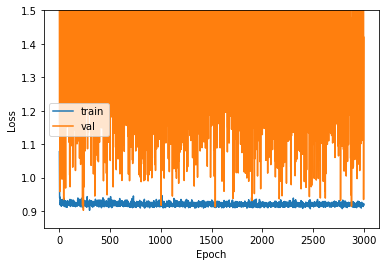

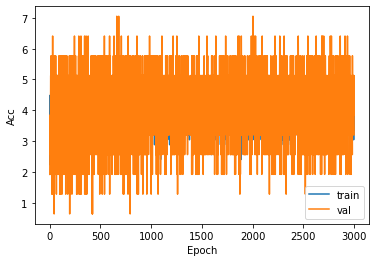

In [358]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(0.85, 1.5)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="train")
plt.plot(x, val_loss, label='val')
plt.legend()
plt.show()

plt.figure()
plt.ylabel("Acc")
plt.xlabel("Epoch")
# plt.ylim(0, 0.01)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_acc, label="train")
plt.plot(x, val_acc, label='val')
plt.legend()
plt.show()

## Correlation of Ground Truth and Prediction

In [349]:
test_loss, correct = 0, 0
with torch.no_grad():
    pred = model(x_tdos_val, x_pdos_r_val, x_pdos_adsorb_val)
    test_loss += loss_fn(pred, y_val).item()
#     correct = torch.sum((torch.abs(pred - y) < torch.abs(0.1* y)))
test_loss /=  len(x_tdos)
print("Loss:", test_loss)

TypeError: forward() takes 2 positional arguments but 4 were given

Corr: -0.0409
Loss: 0.0000


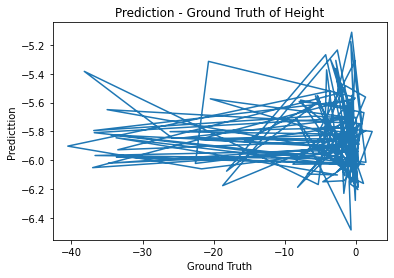

In [350]:
from scipy.stats import pearsonr

# print(y_val.cpu().shape)
# print(pred.cpu().numpy()[:,0])
plt.title( "Prediction - Ground Truth of Height")
plt.xlabel( "Ground Truth")
plt.ylabel( "Predicttion")
plt.plot( y_val.cpu().numpy(), pred.cpu().numpy()[:,0] )# plot( x, y)
corr, _ = pearsonr(y_val.cpu().numpy(), pred.cpu().numpy()[:,0])
slope = "Corr: " + "%.4f"%corr + "\nLoss: " + "%.4f"%test_loss
print(slope)
# plt.text( 0, , slope)
plt.show()

In [351]:
print(pred) 
print(y_val)

tensor([[-5.6585],
        [-5.4816],
        [-5.5612],
        [-6.0075],
        [-5.3723],
        [-5.8654],
        [-5.8435],
        [-5.7070],
        [-5.1759],
        [-6.0140],
        [-5.8084],
        [-5.7028],
        [-6.0392],
        [-5.8002],
        [-5.7642],
        [-5.7938],
        [-5.8682],
        [-5.5732],
        [-5.7007],
        [-5.8863],
        [-6.2297],
        [-5.7434],
        [-6.1694],
        [-5.5823],
        [-5.6692],
        [-5.9861],
        [-5.3628],
        [-6.1647],
        [-6.2035],
        [-5.8550],
        [-5.1111],
        [-5.7467],
        [-5.6485],
        [-5.9294],
        [-5.6096],
        [-5.3012],
        [-5.7912],
        [-6.0723],
        [-5.7543],
        [-5.7730],
        [-5.8014],
        [-5.8174],
        [-5.8311],
        [-6.1475],
        [-6.4836],
        [-5.7073],
        [-5.9611],
        [-5.9913],
        [-6.1494],
        [-6.1420],
        [-6.0974],
        [-5.8976],
        [-6.